# **Sentiment Analysis**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---



# Libraries

**Data Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**NLP Text Libraries**

In [ ]:
import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**EDA Analysis**

In [ ]:
# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

**Feature Engineering**

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Resampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Splitting Dataset
from sklearn.model_selection import train_test_split

**Model Selection and Evaluation**

In [ ]:
# Model Building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



---



# The Dataset

**Read The Dataset**

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Instruments_Reviews.csv")

**Shape of The Dataset**

In [ ]:
dataset.shape

(10261, 9)

*From this, we can infer that the dataset consists of 10261 rows and 9 columns.*



---



# Data Preprocessing

**Checking Null Values**

In [ ]:
dataset.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,27
helpful,0
reviewText,7
overall,0
summary,0
unixReviewTime,0
reviewTime,0


**Filling Missing Values**

In [ ]:
dataset.reviewText.fillna(value = "", inplace = True)

**Concatenate `reviewText` and `summary` Columns**

In [ ]:
dataset["reviews"] = dataset["reviewText"] + " " + dataset["summary"]
dataset.drop(columns = ["reviewText", "summary"], axis = 1, inplace = True)

**Statistic Description of The Dataset**

In [ ]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10261
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013","These strings are really quite good, but I wou..."
freq,42,163,66,6796,NaN,NaN,40,1
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN


**Percentages of Ratings Given from The Customers**

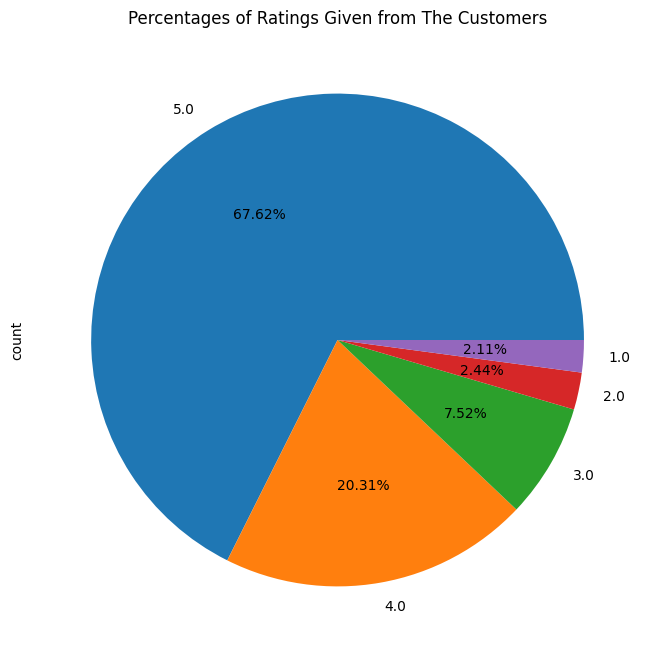

In [ ]:
dataset.overall.value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(8,8))
plt.title("Percentages of Ratings Given from The Customers", loc = "center")
plt.show()

**Labelling Products Based On Ratings Given**

In [ ]:
def Labelling(Rows):
  if(Rows["overall"] > 3.0):
    Label = "Positive"
  elif(Rows["overall"] < 3.0):
    Label = "Negative"
  else:
    Label = "Neutral"
  return Label

In [ ]:
dataset["sentiment"] = dataset.apply(Labelling, axis = 1)

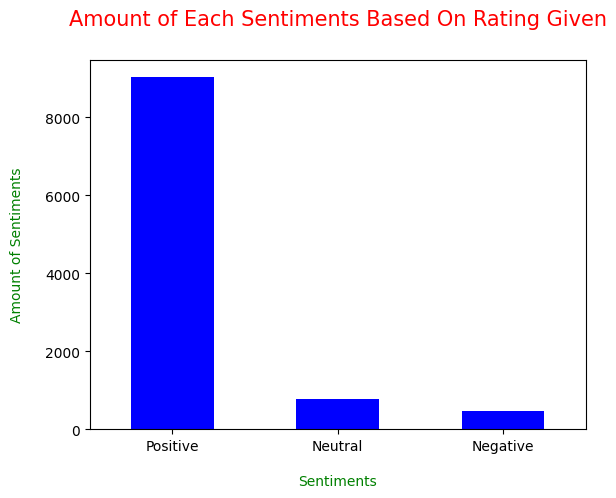

In [ ]:
dataset["sentiment"].value_counts().plot(kind = "bar", color = "blue")
plt.title("Amount of Each Sentiments Based On Rating Given", loc = "center", fontsize = 15, color = "red", pad = 25)
plt.xlabel("Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Amount of Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.show()

*In this part we can actually change the labels into numeric values but for the sake of experiments we will do it later. Also, notice that from the graph we can know that most of our data contains positive sentiments, which is true from the exploration before.*



---



# Text Preprocessing

**Text Cleaning**

In [ ]:
def Text_Cleaning(Text):
  # Lowercase the texts
  Text = Text.lower()

  # Cleaning punctuations in the text
  punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  Text = Text.translate(punc)

  # Removing numbers in the text
  Text = re.sub(r'\d+', '', Text)

  # Remove possible links
  Text = re.sub('https?://\S+|www\.\S+', '', Text)

  # Deleting newlines
  Text = re.sub('\n', '', Text)

  return Text

**Text Processing**

In [ ]:
# Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
  Processed_Text = list()
  Lemmatizer = WordNetLemmatizer()

  # Tokens of Words
  Tokens = nltk.word_tokenize(Text)

  # Removing Stopwords and Lemmatizing Words
  # To reduce noises in our dataset, also to keep it simple and still
  # powerful, we will only omit the word `not` from the list of stopwords

  for word in Tokens:
    if word not in Stopwords:
      Processed_Text.append(Lemmatizer.lemmatize(word))

  return(" ".join(Processed_Text))

**Applying The Functions**

In [ ]:
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Cleaning(Text))
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Processing(Text))



---



# Exploratory Data Analysis

**Overview of The Dataset**

In [ ]:
dataset.head(n = 10)

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sou...,Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized ...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwis...,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop ...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio fil...,Positive
5,A2A039TZMZHH9Y,B00004Y2UT,"Bill Lewey ""blewey""","[0, 0]",5.0,1356048000,"12 21, 2012",good bought another one love heavy cord gold c...,Positive
6,A1UPZM995ZAH90,B00004Y2UT,Brian,"[0, 0]",5.0,1390089600,"01 19, 2014",used monster cable year good reason lifetime w...,Positive
7,AJNFQI3YR6XJ5,B00004Y2UT,"Fender Guy ""Rick""","[0, 0]",3.0,1353024000,"11 16, 2012",use cable run output pedal chain input fender ...,Neutral
8,A3M1PLEYNDEYO8,B00004Y2UT,"G. Thomas ""Tom""","[0, 0]",5.0,1215302400,"07 6, 2008",perfect epiphone sheraton ii monster cable wel...,Positive
9,AMNTZU1YQN1TH,B00004Y2UT,Kurt Robair,"[0, 0]",5.0,1389139200,"01 8, 2014",monster make best cable lifetime warranty does...,Positive


*With the overview above, we know that for sentiment analysis that we will do, `reviews` is important to our model and we should use this aspect as our feature. By using this feature, we will need to predict what our sentiment will be classified into.*

**About Other Features**

In [ ]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10254,3
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013",good string five star,Positive
freq,42,163,66,6796,NaN,NaN,40,3,9022
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN,NaN


*Now, we will go back to statistic description of our dataset. Intuitively, the other features from our dataset does not really have any impact in determining our sentiment later. We might use the `helpful` part in our model, but as we can see from the description above, the top values of it is [0,0], which means that most users do not really take their votes in it. Because of it, we can also decide that we don't really need it in our model.*

**Polarity, Review Length, and Word Counts**

*To justify our analysis before, we will dive further into the dataset a bit more from the polarity of the texts, also from the words used in the reviews. We will generate some new columns in our dataset and visualize it.*

Polarity

In [ ]:
dataset["polarity"] = dataset["reviews"].map(lambda Text: TextBlob(Text).sentiment.polarity)

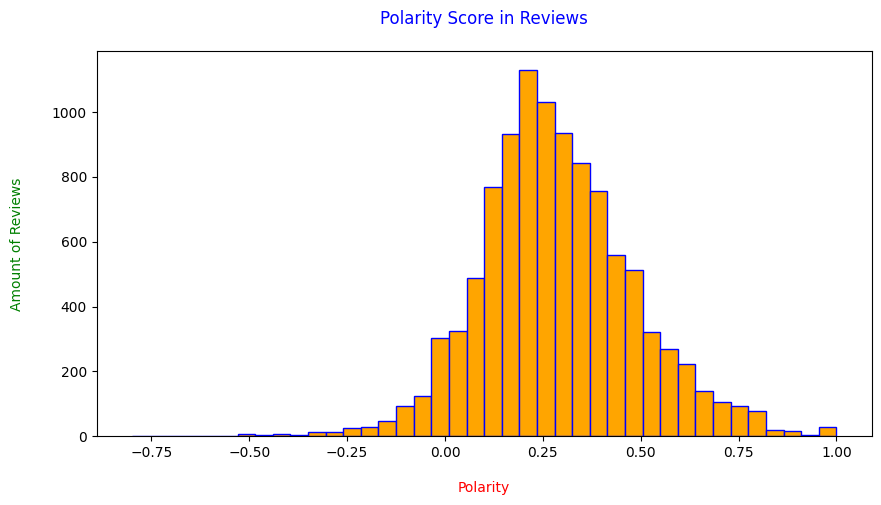

In [ ]:
dataset["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Polarity Score in Reviews", color = "blue", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

*Reviews with negative polarity will be in range of [-1, 0), neutral ones will be 0.0, and positive reviews will have the range of (0, 1].*

*From the histogram above, we know that most of the reviews are distributed in positive sentiments, meaning that what we extracted from our analysis before is true. Statistically, this histogram shows that our data is normally distributed, but not with standard distribution. In conclusion, we know for sure that our analysis about the amount of sentiments from the reviews is correct and corresponds to the histogram above.*

Review Length

In [ ]:
dataset["length"] = dataset["reviews"].astype(str).apply(len)

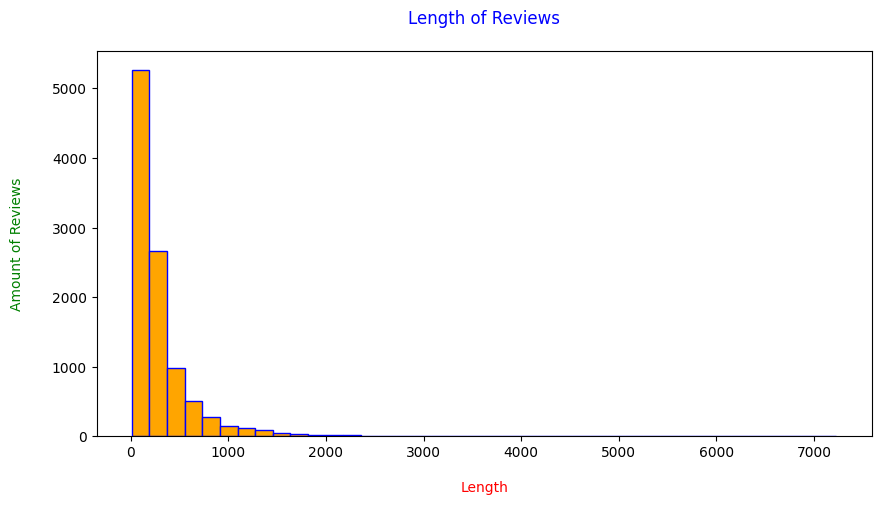

In [ ]:
dataset["length"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Length of Reviews", color = "blue", pad = 20)
plt.xlabel("Length", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

*Based on this, we know that our review has text length between approximately 0-1000 characters. The distribution itself has positive skewness, or in other words it is skewed right, and this means that our reviews rarely has larger length than 1000 characters. Of course, the review that we use here is affected by the text preprocessing phase, so the length might not be the actual value of the review itself as some words might have been omitted already. This will also have the same effect when we count the tatal of words in our reviews.*

Word Counts

In [ ]:
dataset["word_counts"] = dataset["reviews"].apply(lambda x: len(str(x).split()))

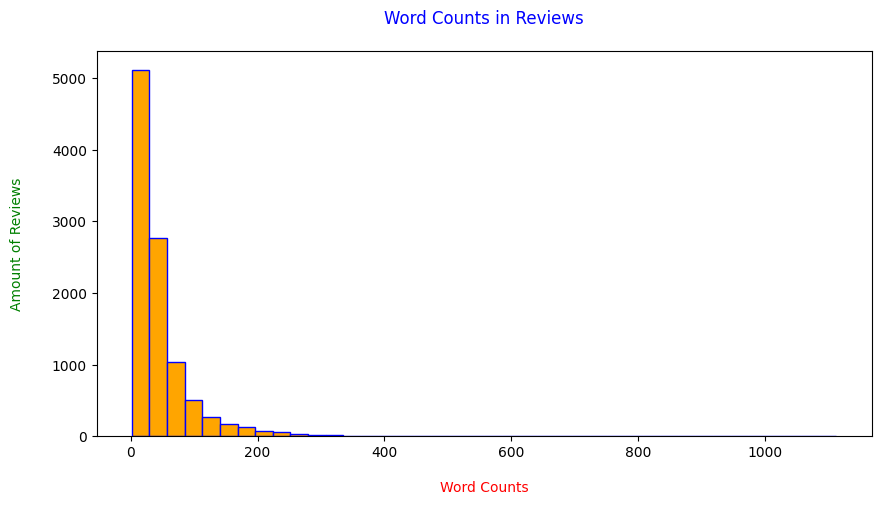

In [ ]:
dataset["word_counts"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Word Counts in Reviews", color = "blue", pad = 20)
plt.xlabel("Word Counts", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

*From the figure above, we infer that most of the reviews consist of 0-200 words. Just like before, the distribution is skewed right and the calculation is affected by our text preprocessing phase before.*



---



# N-Gram Analysis

**N-Gram Function**

In [ ]:
def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  Vectorizer = CountVectorizer(stop_words = Stopwords, ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

**Filter The DataFrame Based On Sentiments**

In [ ]:
# Use dropna() so the base DataFrame is not affected
Positive = dataset[dataset["sentiment"] == "Positive"].dropna()
Neutral = dataset[dataset["sentiment"] == "Neutral"].dropna()
Negative = dataset[dataset["sentiment"] == "Negative"].dropna()

**Unigram of Reviews Based on Sentiments**

In [ ]:
# Finding Unigram
words = Gram_Analysis(Positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got {"you'll", 'through', 'ain', 'then', 'these', 'but', "that'll", 't', 'myself', "you'd", 'themselves', 'to', 'he', 'mustn', 'yourselves', 'was', 'against', 'there', 'further', 'no', 'same', 'theirs', 'at', 'whom', 'here', 'being', 'who', 'over', 'a', 'didn', 'again', 'this', 'she', 'has', 'once', 'will', 'himself', 'under', 'nor', 'other', 'up', "should've", 'were', "you're", 'with', 'why', 'an', "haven't", 'am', 'down', "don't", 'had', 'having', 'them', 'been', 'as', 'below', "hasn't", "weren't", 'couldn', 'during', 'have', "aren't", "doesn't", 'doing', 'they', 'all', 'its', "won't", 'ours', "wasn't", 'won', 'between', 'above', 'did', 'yours', 'we', 'his', 'shouldn', 'yourself', 'hasn', "you've", 'weren', 'than', 'from', 'by', 'our', 'in', 'be', 'y', 'while', 'so', 'isn', 'haven', 'own', "wouldn't", 'ma', 'what', 'their', 'about', 'just', 'shan', 'if', 'where', 'for', 'i', 'of', 'll', 'wasn', 'don', 'aren', 'it', 'after', "mustn't", "shan't", 'out', 'few', 'itself', 'are', 've', 'mightn', "shouldn't", 'him', 'the', 'my', 'only', 'into', 'can', 'herself', 'off', 'before', 'too', 'ourselves', 'o', 'any', 'do', 'such', 'd', 'how', 'more', 'on', 'now', 'm', 'should', 'which', 'those', 'both', 'doesn', 'me', 'or', 'each', "mightn't", 'needn', 'that', 'very', "hadn't", "isn't", 'her', "couldn't", 'most', 'when', 'because', 'some', "didn't", 'you', 's', 're', "it's", 'your', 'hadn', 'until', "needn't", 'and', "she's", 'hers', 'is', 'does', 'wouldn'} instead.

In [ ]:
# Finding Unigram
words = Gram_Analysis(Neutral["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Unigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got {"you'll", 'through', 'ain', 'then', 'these', 'but', "that'll", 't', 'myself', "you'd", 'themselves', 'to', 'he', 'mustn', 'yourselves', 'was', 'against', 'there', 'further', 'no', 'same', 'theirs', 'at', 'whom', 'here', 'being', 'who', 'over', 'a', 'didn', 'again', 'this', 'she', 'has', 'once', 'will', 'himself', 'under', 'nor', 'other', 'up', "should've", 'were', "you're", 'with', 'why', 'an', "haven't", 'am', 'down', "don't", 'had', 'having', 'them', 'been', 'as', 'below', "hasn't", "weren't", 'couldn', 'during', 'have', "aren't", "doesn't", 'doing', 'they', 'all', 'its', "won't", 'ours', "wasn't", 'won', 'between', 'above', 'did', 'yours', 'we', 'his', 'shouldn', 'yourself', 'hasn', "you've", 'weren', 'than', 'from', 'by', 'our', 'in', 'be', 'y', 'while', 'so', 'isn', 'haven', 'own', "wouldn't", 'ma', 'what', 'their', 'about', 'just', 'shan', 'if', 'where', 'for', 'i', 'of', 'll', 'wasn', 'don', 'aren', 'it', 'after', "mustn't", "shan't", 'out', 'few', 'itself', 'are', 've', 'mightn', "shouldn't", 'him', 'the', 'my', 'only', 'into', 'can', 'herself', 'off', 'before', 'too', 'ourselves', 'o', 'any', 'do', 'such', 'd', 'how', 'more', 'on', 'now', 'm', 'should', 'which', 'those', 'both', 'doesn', 'me', 'or', 'each', "mightn't", 'needn', 'that', 'very', "hadn't", "isn't", 'her', "couldn't", 'most', 'when', 'because', 'some', "didn't", 'you', 's', 're', "it's", 'your', 'hadn', 'until', "needn't", 'and', "she's", 'hers', 'is', 'does', 'wouldn'} instead.

In [ ]:
# Finding Unigram
words = Gram_Analysis(Negative["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Unigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got {"you'll", 'through', 'ain', 'then', 'these', 'but', "that'll", 't', 'myself', "you'd", 'themselves', 'to', 'he', 'mustn', 'yourselves', 'was', 'against', 'there', 'further', 'no', 'same', 'theirs', 'at', 'whom', 'here', 'being', 'who', 'over', 'a', 'didn', 'again', 'this', 'she', 'has', 'once', 'will', 'himself', 'under', 'nor', 'other', 'up', "should've", 'were', "you're", 'with', 'why', 'an', "haven't", 'am', 'down', "don't", 'had', 'having', 'them', 'been', 'as', 'below', "hasn't", "weren't", 'couldn', 'during', 'have', "aren't", "doesn't", 'doing', 'they', 'all', 'its', "won't", 'ours', "wasn't", 'won', 'between', 'above', 'did', 'yours', 'we', 'his', 'shouldn', 'yourself', 'hasn', "you've", 'weren', 'than', 'from', 'by', 'our', 'in', 'be', 'y', 'while', 'so', 'isn', 'haven', 'own', "wouldn't", 'ma', 'what', 'their', 'about', 'just', 'shan', 'if', 'where', 'for', 'i', 'of', 'll', 'wasn', 'don', 'aren', 'it', 'after', "mustn't", "shan't", 'out', 'few', 'itself', 'are', 've', 'mightn', "shouldn't", 'him', 'the', 'my', 'only', 'into', 'can', 'herself', 'off', 'before', 'too', 'ourselves', 'o', 'any', 'do', 'such', 'd', 'how', 'more', 'on', 'now', 'm', 'should', 'which', 'those', 'both', 'doesn', 'me', 'or', 'each', "mightn't", 'needn', 'that', 'very', "hadn't", "isn't", 'her', "couldn't", 'most', 'when', 'because', 'some', "didn't", 'you', 's', 're', "it's", 'your', 'hadn', 'until', "needn't", 'and', "she's", 'hers', 'is', 'does', 'wouldn'} instead.

*These unigrams are not really accurate, because we can clearly see that even for postive sentiments, the top unigram is the wird `guitar` which is an object, though from here we might know that the most frequently bought items are guitars or the complement of it. We should try to find the bigram and see how accurate it can describe each sentiments*

**Bigram of Reviews Based On Sentiments**

In [ ]:
# Finding Bigram
words = Gram_Analysis(Positive["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got {"you'll", 'through', 'ain', 'then', 'these', 'but', "that'll", 't', 'myself', "you'd", 'themselves', 'to', 'he', 'mustn', 'yourselves', 'was', 'against', 'there', 'further', 'no', 'same', 'theirs', 'at', 'whom', 'here', 'being', 'who', 'over', 'a', 'didn', 'again', 'this', 'she', 'has', 'once', 'will', 'himself', 'under', 'nor', 'other', 'up', "should've", 'were', "you're", 'with', 'why', 'an', "haven't", 'am', 'down', "don't", 'had', 'having', 'them', 'been', 'as', 'below', "hasn't", "weren't", 'couldn', 'during', 'have', "aren't", "doesn't", 'doing', 'they', 'all', 'its', "won't", 'ours', "wasn't", 'won', 'between', 'above', 'did', 'yours', 'we', 'his', 'shouldn', 'yourself', 'hasn', "you've", 'weren', 'than', 'from', 'by', 'our', 'in', 'be', 'y', 'while', 'so', 'isn', 'haven', 'own', "wouldn't", 'ma', 'what', 'their', 'about', 'just', 'shan', 'if', 'where', 'for', 'i', 'of', 'll', 'wasn', 'don', 'aren', 'it', 'after', "mustn't", "shan't", 'out', 'few', 'itself', 'are', 've', 'mightn', "shouldn't", 'him', 'the', 'my', 'only', 'into', 'can', 'herself', 'off', 'before', 'too', 'ourselves', 'o', 'any', 'do', 'such', 'd', 'how', 'more', 'on', 'now', 'm', 'should', 'which', 'those', 'both', 'doesn', 'me', 'or', 'each', "mightn't", 'needn', 'that', 'very', "hadn't", "isn't", 'her', "couldn't", 'most', 'when', 'because', 'some', "didn't", 'you', 's', 're', "it's", 'your', 'hadn', 'until', "needn't", 'and', "she's", 'hers', 'is', 'does', 'wouldn'} instead.

In [ ]:
# Finding Bigram
words = Gram_Analysis(Neutral["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

In [ ]:
# Finding Bigram
words = Gram_Analysis(Negative["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got {"you'll", 'through', 'ain', 'then', 'these', 'but', "that'll", 't', 'myself', "you'd", 'themselves', 'to', 'he', 'mustn', 'yourselves', 'was', 'against', 'there', 'further', 'no', 'same', 'theirs', 'at', 'whom', 'here', 'being', 'who', 'over', 'a', 'didn', 'again', 'this', 'she', 'has', 'once', 'will', 'himself', 'under', 'nor', 'other', 'up', "should've", 'were', "you're", 'with', 'why', 'an', "haven't", 'am', 'down', "don't", 'had', 'having', 'them', 'been', 'as', 'below', "hasn't", "weren't", 'couldn', 'during', 'have', "aren't", "doesn't", 'doing', 'they', 'all', 'its', "won't", 'ours', "wasn't", 'won', 'between', 'above', 'did', 'yours', 'we', 'his', 'shouldn', 'yourself', 'hasn', "you've", 'weren', 'than', 'from', 'by', 'our', 'in', 'be', 'y', 'while', 'so', 'isn', 'haven', 'own', "wouldn't", 'ma', 'what', 'their', 'about', 'just', 'shan', 'if', 'where', 'for', 'i', 'of', 'll', 'wasn', 'don', 'aren', 'it', 'after', "mustn't", "shan't", 'out', 'few', 'itself', 'are', 've', 'mightn', "shouldn't", 'him', 'the', 'my', 'only', 'into', 'can', 'herself', 'off', 'before', 'too', 'ourselves', 'o', 'any', 'do', 'such', 'd', 'how', 'more', 'on', 'now', 'm', 'should', 'which', 'those', 'both', 'doesn', 'me', 'or', 'each', "mightn't", 'needn', 'that', 'very', "hadn't", "isn't", 'her', "couldn't", 'most', 'when', 'because', 'some', "didn't", 'you', 's', 're', "it's", 'your', 'hadn', 'until', "needn't", 'and', "she's", 'hers', 'is', 'does', 'wouldn'} instead.

*The bigrams work better than the unigrams, because we can actually see some phrases that really describe what a good sentiment is. Although, in some parts we can still see guitar objects as the top words, which make us believe that our interpretation about the most selling items are related to guitars.*

**Trigram of Reviews Based On Sentiments**

In [ ]:
# Finding Trigram
words = Gram_Analysis(Positive["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got {"you'll", 'through', 'ain', 'then', 'these', 'but', "that'll", 't', 'myself', "you'd", 'themselves', 'to', 'he', 'mustn', 'yourselves', 'was', 'against', 'there', 'further', 'no', 'same', 'theirs', 'at', 'whom', 'here', 'being', 'who', 'over', 'a', 'didn', 'again', 'this', 'she', 'has', 'once', 'will', 'himself', 'under', 'nor', 'other', 'up', "should've", 'were', "you're", 'with', 'why', 'an', "haven't", 'am', 'down', "don't", 'had', 'having', 'them', 'been', 'as', 'below', "hasn't", "weren't", 'couldn', 'during', 'have', "aren't", "doesn't", 'doing', 'they', 'all', 'its', "won't", 'ours', "wasn't", 'won', 'between', 'above', 'did', 'yours', 'we', 'his', 'shouldn', 'yourself', 'hasn', "you've", 'weren', 'than', 'from', 'by', 'our', 'in', 'be', 'y', 'while', 'so', 'isn', 'haven', 'own', "wouldn't", 'ma', 'what', 'their', 'about', 'just', 'shan', 'if', 'where', 'for', 'i', 'of', 'll', 'wasn', 'don', 'aren', 'it', 'after', "mustn't", "shan't", 'out', 'few', 'itself', 'are', 've', 'mightn', "shouldn't", 'him', 'the', 'my', 'only', 'into', 'can', 'herself', 'off', 'before', 'too', 'ourselves', 'o', 'any', 'do', 'such', 'd', 'how', 'more', 'on', 'now', 'm', 'should', 'which', 'those', 'both', 'doesn', 'me', 'or', 'each', "mightn't", 'needn', 'that', 'very', "hadn't", "isn't", 'her', "couldn't", 'most', 'when', 'because', 'some', "didn't", 'you', 's', 're', "it's", 'your', 'hadn', 'until', "needn't", 'and', "she's", 'hers', 'is', 'does', 'wouldn'} instead.

In [ ]:
# Finding Trigram
words = Gram_Analysis(Neutral["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

InvalidParameterError: The 'stop_words' parameter of CountVectorizer must be a str among {'english'}, an instance of 'list' or None. Got {"you'll", 'through', 'ain', 'then', 'these', 'but', "that'll", 't', 'myself', "you'd", 'themselves', 'to', 'he', 'mustn', 'yourselves', 'was', 'against', 'there', 'further', 'no', 'same', 'theirs', 'at', 'whom', 'here', 'being', 'who', 'over', 'a', 'didn', 'again', 'this', 'she', 'has', 'once', 'will', 'himself', 'under', 'nor', 'other', 'up', "should've", 'were', "you're", 'with', 'why', 'an', "haven't", 'am', 'down', "don't", 'had', 'having', 'them', 'been', 'as', 'below', "hasn't", "weren't", 'couldn', 'during', 'have', "aren't", "doesn't", 'doing', 'they', 'all', 'its', "won't", 'ours', "wasn't", 'won', 'between', 'above', 'did', 'yours', 'we', 'his', 'shouldn', 'yourself', 'hasn', "you've", 'weren', 'than', 'from', 'by', 'our', 'in', 'be', 'y', 'while', 'so', 'isn', 'haven', 'own', "wouldn't", 'ma', 'what', 'their', 'about', 'just', 'shan', 'if', 'where', 'for', 'i', 'of', 'll', 'wasn', 'don', 'aren', 'it', 'after', "mustn't", "shan't", 'out', 'few', 'itself', 'are', 've', 'mightn', "shouldn't", 'him', 'the', 'my', 'only', 'into', 'can', 'herself', 'off', 'before', 'too', 'ourselves', 'o', 'any', 'do', 'such', 'd', 'how', 'more', 'on', 'now', 'm', 'should', 'which', 'those', 'both', 'doesn', 'me', 'or', 'each', "mightn't", 'needn', 'that', 'very', "hadn't", "isn't", 'her', "couldn't", 'most', 'when', 'because', 'some', "didn't", 'you', 's', 're', "it's", 'your', 'hadn', 'until', "needn't", 'and', "she's", 'hers', 'is', 'does', 'wouldn'} instead.

In [ ]:
# Finding Trigram
words = Gram_Analysis(Negative["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

*We can say that the trigrams are slightly better to describe each sentiments, although negative trigrams say a lot about bad products which we can infer from the top words above. From the N-Gram Analysis, we can also see how the decision of not removing `not` in our list of stopwords affects our data as we keep the meaning of negation phrases.*



---



# Word Clouds

**Word Cloud of Reviews with Positive Sentiments**

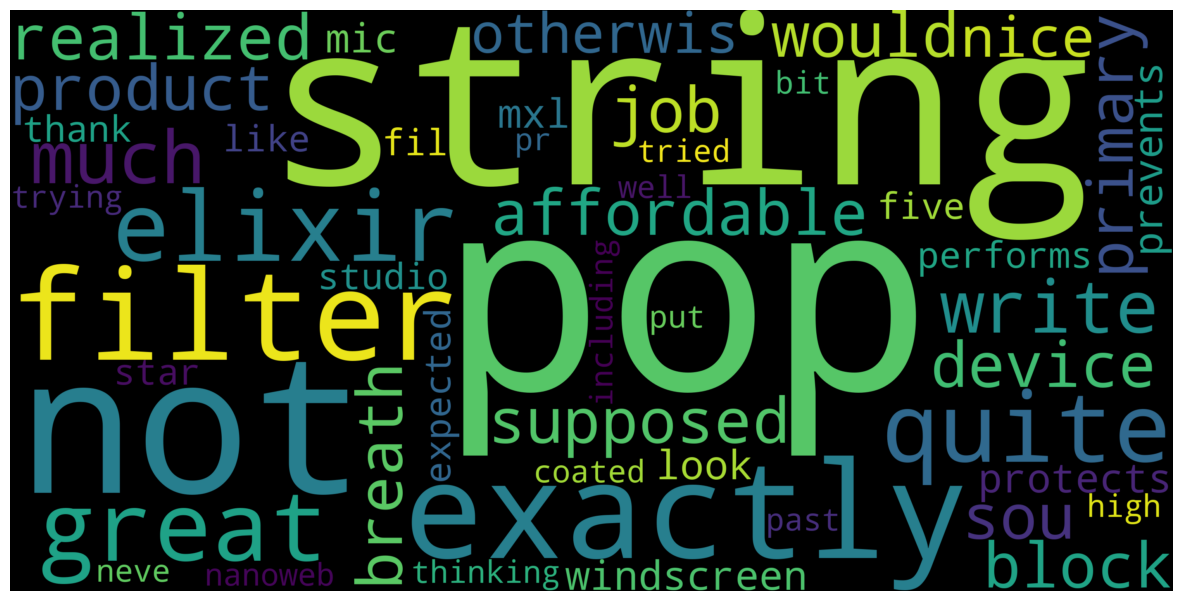

In [ ]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Positive["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

**Word Cloud of Reviews with Neutral Sentiments**

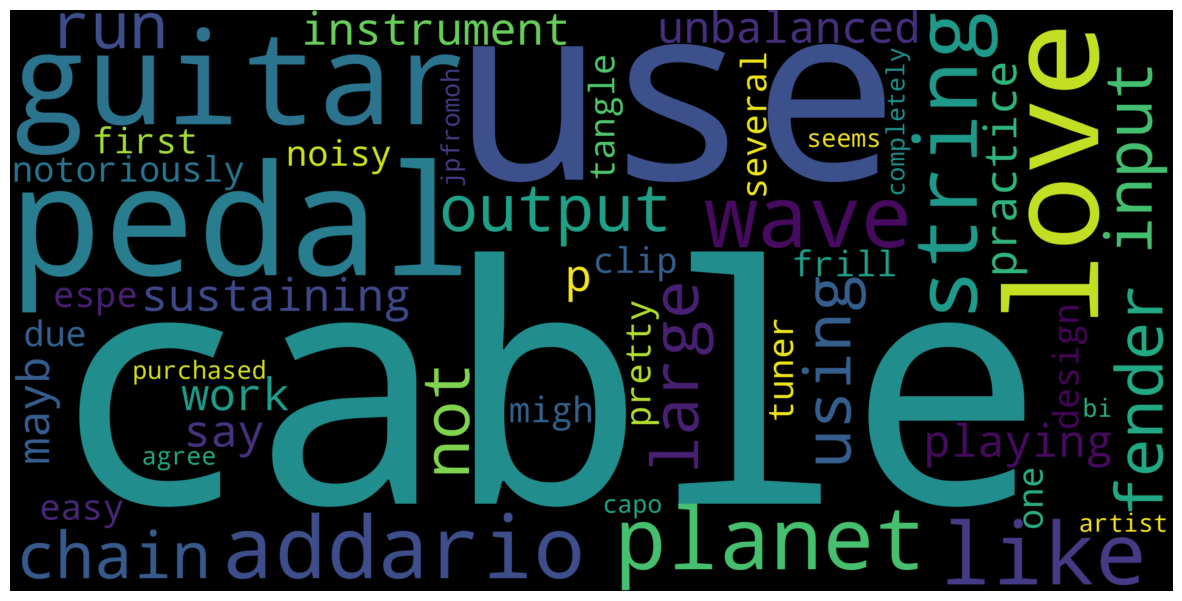

In [ ]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Neutral["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

**Word Cloud of Reviews with Negative Sentiments**

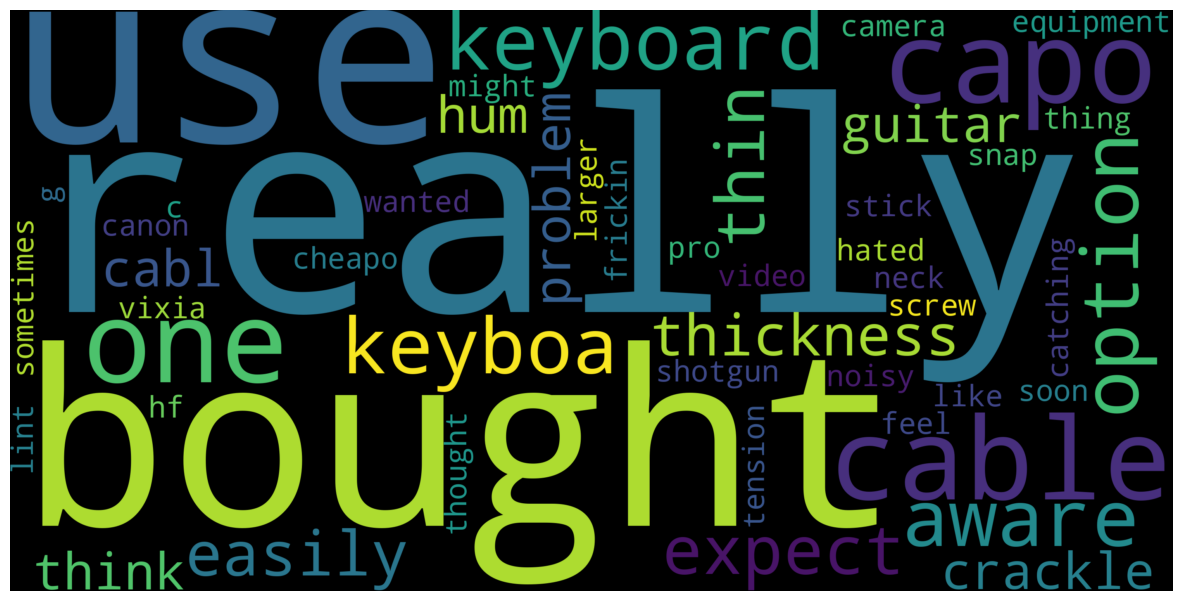

In [ ]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Negative["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

*From these word clouds, not only we can see words that really describe our sentiments, but just like our N-Grams Analysis we can see objects being discussed in the reviews given.*



---



# Feature Engineering

**Drop Insignificant Columns**

In [ ]:
Columns = ["reviewerID", "asin", "reviewerName", "helpful", "unixReviewTime", "reviewTime", "polarity", "length", "word_counts", "overall"]
dataset.drop(columns = Columns, axis = 1, inplace = True)

*We dropped these columns to make our dataset concise. We now have two columns as our independent variables and the last column as dependent variables. To continue, we must encode our label as a set of numbers corresponding to each categories of it.*

**Current State of The Dataset**

In [ ]:
dataset.head()

,reviews,sentiment
0,not much write exactly supposed filter pop sou...,Positive
1,product exactly quite affordable not realized ...,Positive
2,primary job device block breath would otherwis...,Positive
3,nice windscreen protects mxl mic prevents pop ...,Positive
4,pop filter great look performs like studio fil...,Positive


**Encoding Our Target Variable**

In [ ]:
Encoder = LabelEncoder()
dataset["sentiment"] = Encoder.fit_transform(dataset["sentiment"])

In [ ]:
dataset["sentiment"].value_counts()

,count
sentiment,
2,9022
1,772
0,467


*We had successfully encoded our sentiment into numbers so that our model can easily figure it out. From above, we know that the label `Positive` is encoded into 2, `Neutral` into 1, and `Negative` into 0. Now, we have to give importance of each words in the whole review, i.e. giving them weights. We can do this by using TF-IDF (Term Frequency - Inverse Document Frequency) Vectorizer.*

**TF-IDF Vectorizer**

In [ ]:
# Defining our vectorizer with total words of 5000 and with bigram model
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

# Fitting and transforming our reviews into a matrix of weighed words
# This will be our independent features
X = TF_IDF.fit_transform(dataset["reviews"])

# Check our matrix shape
X.shape

(10261, 5000)

In [ ]:
# Declaring our target variable
y = dataset["sentiment"]

*From the shape, we successfully transformed our reviews with TF-IDF Vectorizer of 7000 top bigram words. Now, as we know from before, our data is kind of imbalanced with very little neutral and negative values compared to positive sentiments. We need to balance our dataset before going into modelling process.*

**Resampling Our Dataset**

*There are many ways to do resampling to an imbalanced dataset, such as SMOTE and Bootstrap Method. We will use SMOTE (Synthetic Minority Oversampling Technique) that will randomly generate new replicates of our undersampling data to balance our dataset.*

In [ ]:
Counter(y)

Counter({2: 9022, 1: 772, 0: 467})

In [ ]:
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

In [ ]:
Counter(y_final)

Counter({2: 9022, 1: 9022, 0: 9022})

*Now our data is already balanced as we can see from the counter of each sentiment categories before and after the resampling with SMOTE.*

**Splitting Our Dataset**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

*We splitted our dataset into 75:25 portion respectively for the training and test set.*



---



# Model Selection and Evaluation

**Model Building**

In [ ]:
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
SVC = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [DTree, LogReg, SVC, RForest, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

for i, model in enumerate(Models):
  print("{} Test Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean()))

Decision Tree Test Accuracy: 0.8214589134309321
Logistic Regression Test Accuracy: 0.8819802942387887
SVC Test Accuracy: 0.8805184008381876
Random Forest Test Accuracy: 0.8775947089404784
Naive Bayes Test Accuracy: 0.8089843238410861
K-Neighbors Test Accuracy: 0.8800310714034898


**Hyperparameter Tuning**

In [ ]:
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 0, n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Best Accuracy: 94.78 %
Best Parameters: {'C': 10000.0, 'penalty': 'l2'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Best Model**

In [ ]:
Classifier = LogisticRegression(random_state = 42, C = 6866.488450042998, penalty = 'l2')
Classifier.fit(X_train, y_train)

Prediction = Classifier.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Metrics**

Accuracy On Test Set

In [ ]:
accuracy_score(y_test, Prediction)

0.9549283286537609

Confusion Matrix

In [ ]:
ConfusionMatrix = confusion_matrix(y_test, Prediction)

Visualizing Our Confusion Matrix

In [ ]:
# Plotting Function for Confusion Matrix
def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Blues):

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title, pad = 20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")

  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  plt.tight_layout()
  plt.xlabel("Predicted Label", labelpad = 20)
  plt.ylabel("Real Label", labelpad = 20)

Unnormalized Confusion Matrix


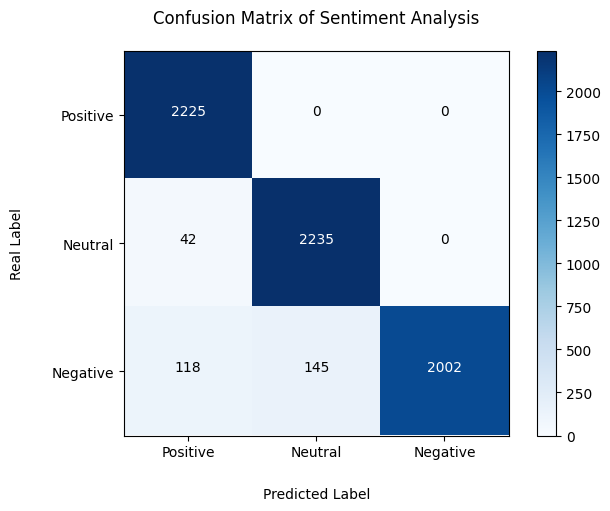

In [ ]:
plot_cm(ConfusionMatrix, classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")

Classification Scores

In [ ]:
print(classification_report(y_test, Prediction))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      2225
           1       0.94      0.98      0.96      2277
           2       1.00      0.88      0.94      2265

    accuracy                           0.95      6767
   macro avg       0.96      0.96      0.95      6767
weighted avg       0.96      0.95      0.95      6767





---





---

